In [1]:
from main import *
from sklearn import clone
from bayes_opt import BayesianOptimization    
import catboost
from catboost import CatBoostClassifier, Pool

DROP_COLS = ["car_ownership", "house_ownership", "married"]

In [2]:
df_train, df_test = data_preprocess([], SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)
df_train.head(10)

Training data shape: (252000, 15) ; Test data shape: (28000, 14)


,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag,income_per_state,income_per_profession,has_house
0,1303835,23,3,1,2,0,33,251,13,3,13,0,4735088.0,5351331.0,0
1,7574516,40,10,1,2,0,43,227,14,9,13,0,5192166.5,4994848.0,0
2,3991815,66,4,0,2,0,47,8,12,4,10,0,5421502.0,4813985.0,0
3,6256451,41,2,1,2,1,43,54,17,2,12,1,4834921.5,4994848.0,0
4,5768871,47,11,1,2,0,11,296,22,3,14,1,5074244.0,5056892.0,0
5,6915937,64,0,1,2,0,11,130,14,0,12,0,5192166.5,5056892.0,0
6,3954973,58,14,0,2,0,31,299,22,8,12,0,5074244.0,5384499.0,0
7,1706172,33,2,1,2,0,20,134,6,2,14,0,5265885.0,4940114.0,0
8,7566849,24,17,1,2,1,25,165,20,11,11,0,5315413.0,4608251.0,0
9,8964846,23,12,1,2,0,2,149,23,5,13,0,4942553.0,4950300.0,0


In [ ]:
col = "current_job_years"
sns.histplot(x=col, data=df_train, label="train", color='g', stat="density", binwidth=1, alpha=0.5)
sns.histplot(x=col, data=df_test, label="test", color='r', stat="density", binwidth=1, alpha=0.5)
plt.show()

<AxesSubplot:xlabel='city', ylabel='state'>

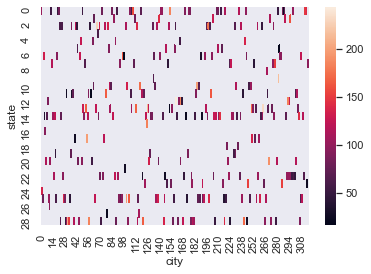

In [15]:
sns.heatmap(df_train.pivot_table(values="risk_flag", index="state", columns="city", aggfunc="sum"))

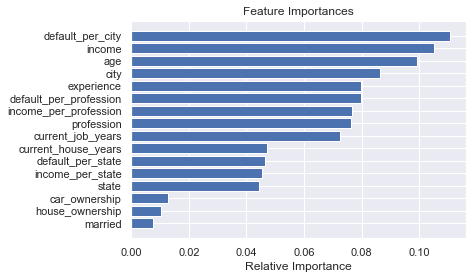

In [3]:
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_features=1)
model = train_model(model, df_train)
features = df_train.drop("risk_flag", axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Training data shape: (252000, 11) ; Test data shape: (28000, 10)
Training data shape: (252000, 17) ; Test data shape: (28000, 16)
Training data shape: (252000, 14) ; Test data shape: (28000, 13)
Training data shape: (252000, 14) ; Test data shape: (28000, 13)


<AxesSubplot:>

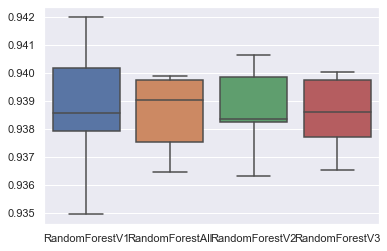

In [4]:
clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_features=1)
models = {
    "RandomForestV1": [clone(clf), ["car_ownership", "house_ownership", "married", "profession", "city", "state"]],
    "RandomForestAll": [clone(clf), []],
    "RandomForestV2": [clone(clf), ["profession", "city", "state"]],
    "RandomForestV3": [clone(clf), ["car_ownership", "house_ownership", "married"]]
}

res = pd.DataFrame.from_dict(
        {model_name: eval_model(model, data_preprocess(drop_cols, SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]) for model_name, (model, drop_cols) in models.items()}    
    )
sns.boxplot(data=res)

In [ ]:
model = RandomForestClassifier(n_estimators=1000, max_features=1, class_weight="balanced", n_jobs=-1)
df_train, df_test = data_preprocess(drop_cols=["car_ownership", "house_ownership", "married"], transform_fns=transforms)
sub = make_submission(model, df_train, df_test)
sub.to_csv("./tuning_rf/sub4.csv")

## Note: can safely remove `["car_ownership", "house_ownership", "married"]`

Training data shape: (252000, 14) ; Test data shape: (28000, 13)


<AxesSubplot:>

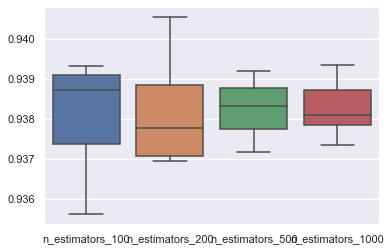

In [2]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]

param = "n_estimators"
par_vals = [100, 200, 500, 1000]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(RandomForestClassifier(n_jobs=-1, **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

## Note: a smaller `max_features` value seems better
---

In [ ]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, [income_by_state])[0]

param = "colsample_bytree"
par_vals = [0.6, 0.7, 0.8, 0.9]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(XGBClassifier(
            n_estimators=200, 
            learning_rate=0.1,
            reg_alpha=1e-3,
            tree_method="gpu_hist",
            scale_pos_weight=12,
            **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

In [ ]:
df_train = data_preprocess([], SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]
sns.heatmap(x="state", y="house_ownership", hue="risk_flag")

In [ ]:
from sklearn.model_selection import train_test_split
def get_model_outputs(models):
    df_train = data_preprocess(
            drop_cols=["car_ownership", "house_ownership", "married"],
            transform_fns=[income_by_state]
        )[0]

    scores = {}
    for name, model in models.items():
        print(f"Cross-validating: {name}")
        scores[name] = eval_model(model, df_train)
    scores = pd.DataFrame.from_dict(scores)
    
    X, y = df_train.drop("risk_flag", axis=1).values, df_train["risk_flag"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    for name in models.keys():
        models[name].fit(X_train, y_train)
    
    preds = {name: model.predict(X_test) for name, model in models.items()}
    return preds, scores

In [1]:
from ensembling import *

In [7]:
df_train = pd.read_csv("./ensemble_files/final_train.csv")
df_train.head()

,id,rfv1_preds,rfv2_preds,dtreev1_preds,dtreev2_preds,dtreev3_preds,etreev1_preds,etreev2_preds,etreev3_preds,targets
0,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,4,1,1,1,0,1,1,1,0,1
4,5,1,0,0,0,0,0,0,0,1


In [8]:
import seaborn as sns
sns.heatmap(df_)

NameError: name 'sns' is not defined

In [9]:
def lightgbm_tuning(df_train):
    df_train = lgb.Dataset(
            data=df_train.drop(["id", "targets"], axis=1).values, 
            label=df_train["targets"].values,
            free_raw_data=False
        )

    def lgb_eval(**params):
        config = {"device": "gpu", "metric": "auc", "boosting_type": "goss", "verbose": -1}
        config.update(params) 

        config["num_leaves"] = int(round(config["num_leaves"]))
        config["max_bin"] = int(round(config["max_bin"]))
        config["max_depth"] = int(round(config["max_depth"]))

        cv_result = lgb.cv(config, df_train, nfold=5, stratified=True, shuffle=True, metrics=["auc"], verbose_eval=False)
        return max(cv_result["auc-mean"])
    
    pbounds = {
        "num_leaves": (80, 250),
        "max_bin": (25, 250),
        "scale_pos_weight": (5, 15),
        "colsample_bytree": (0.1, 0.9),
        "subsample": (0.1, 0.9),
        "max_depth": (2, 25)
    }

    lgBO = BayesianOptimization(lgb_eval, pbounds)
    lgBO.maximize(init_points=15, n_iter=25)
    
    return lgBO

def xgboost_tuning(df_train):
    df_train = xgb.DMatrix(
            df_train.drop(["Id", "risk_flag"], axis=1).values, 
            label=df_train["risk_flag"].values,
        )
    
    def xgb_eval(**params):
        config = {"tree_method": "gpu_hist", "eval_metric": ["auc"], "learning_rate": 0.1}
        config.update(params)
        
        config["max_depth"] = int(round(config["max_depth"]))
        config["min_child_weight"] = int(round(config["min_child_weight"]))
        
        cv_result = xgb.cv(config, df_train, nfold=5, stratified=True, shuffle=True, metrics=["auc"], verbose_eval=False)
        return max(cv_result["test-auc-mean"])
    
    pbounds = {
        "max_depth": (5, 25),
        "min_child_weight": (2, 16),
        "colsample_bytree": (0.1, 0.9),
        "subsample": (0.1, 0.9),
        "gamma": (0.1, 1.0),
        "scale_pos_weight": (5, 15)
    }
    
    xgBO = BayesianOptimization(xgb_eval, pbounds)
    xgBO.maximize(init_points=20, n_iter=40)
    
    return xgBO

In [10]:
# df_train, df_test = data_preprocess(
#     drop_cols=[],
#     transforms=SINGLE_TRANSFORMS
# )

df_train = pd.read_csv("./ensemble_files/final_train.csv")
lgBO = lightgbm_tuning(df_train)

# xgBO = xgboost_tuning(df_train)

|   iter    |  target   | colsam... |  max_bin  | max_depth | num_le... | scale_... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9424   |  0.4094   |  127.5    |  13.6     |  97.32    |  14.17    |  0.7335   |
|  2        |  0.9424   |  0.4387   |  215.5    |  9.407    |  115.7    |  12.64    |  0.1697   |
|  3        |  0.941    |  0.2748   |  119.0    |  17.84    |  143.4    |  12.67    |  0.258    |
|  4        |  0.9411   |  0.2834   |  96.19    |  6.896    |  128.3    |  13.86    |  0.4537   |
|  5        |  0.9428   |  0.7911   |  164.3    |  17.57    |  142.8    |  9.339    |  0.4236   |
|  6        |  0.9411   |  0.1909   |  86.11    |  12.91    |  122.4    |  12.69    |  0.2878   |
|  7        |  0.9417   |  0.3144   |  54.97    |  24.49    |  145.6    |  8.762    |  0.6551   |
|  8        |  0.9428   |  0.6377   |  173.2    |  7.812    |  190.8    |  10.55    |  0.8193   |
|  9        |  0.941

KeyboardInterrupt: 

In [19]:
lgBO.max

{'target': 0.9342476968886055,
 'params': {'colsample_bytree': 0.711263693734104,
  'max_bin': 191.1520924638712,
  'max_depth': 24.719186409019578,
  'num_leaves': 298.8966232805185,
  'scale_pos_weight': 12.23110875213706,
  'subsample': 0.2390470406490695}}

In [1]:
from main import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "n_neighbors": [500, 1000, 1500, 2000, 2500],
    "weights": ["uniform","distance"],   
}
gsearch = GridSearchCV(KNeighborsClassifier(), params, scoring="roc_auc", n_jobs=1, cv=5, refit=False, verbose=2, error_score="raise")

df_train = data_preprocess()[0]
X, y = df_train.drop(["Id", "risk_flag"], axis=1).values, df_train["risk_flag"].values
gsearch.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_neighbors=500, weights=uniform ................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ................. n_neighbors=500, weights=uniform, total=   8.7s
[CV] n_neighbors=500, weights=uniform ................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s
[CV] ................. n_neighbors=500, weights=uniform, total=   8.8s
[CV] n_neighbors=500, weights=uniform ................................
[CV] ................. n_neighbors=500, weights=uniform, total=   8.6s
[CV] n_neighbors=500, weights=uniform ................................
[CV] ................. n_neighbors=500, weights=uniform, total=   8.7s
[CV] n_neighbors=500, weights=uniform ................................
[CV] ................. n_neighbors=500, weights=uniform, total=   8.5s
[CV] n_neighbors=500, weights=distance .............................

GridSearchCV(cv=5, error_score='raise', estimator=KNeighborsClassifier(),
             n_jobs=1,
             param_grid={'n_neighbors': [500, 1000, 1500, 2000, 2500],
                         'weights': ['uniform', 'distance']},
             refit=False, scoring='roc_auc', verbose=2)

In [4]:
pd.DataFrame.from_dict(gsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.185468,0.062411,7.464612,0.063349,500,uniform,"{'n_neighbors': 500, 'weights': 'uniform'}",0.663458,0.663374,0.661979,0.633544,0.512956,0.627062,0.058180,6
1,1.146768,0.034372,7.299572,0.203059,500,distance,"{'n_neighbors': 500, 'weights': 'distance'}",0.975025,0.968333,0.957868,0.936038,0.651035,0.897660,0.124018,1
2,1.140496,0.047237,15.005584,0.219786,1000,uniform,"{'n_neighbors': 1000, 'weights': 'uniform'}",0.613115,0.614951,0.612892,0.591278,0.504058,0.587259,0.042499,7
3,1.142237,0.044241,15.041417,0.056523,1000,distance,"{'n_neighbors': 1000, 'weights': 'distance'}",0.975025,0.968333,0.957868,0.935975,0.650791,0.897598,0.124111,2
4,1.184580,0.119877,23.093925,0.207082,1500,uniform,"{'n_neighbors': 1500, 'weights': 'uniform'}",0.573412,0.574988,0.578088,0.560866,0.501622,0.557795,0.028692,9
5,1.135286,0.047177,23.275972,0.223319,1500,distance,"{'n_neighbors': 1500, 'weights': 'distance'}",0.975025,0.968333,0.957868,0.935950,0.650685,0.897572,0.124151,5
6,1.147162,0.046443,30.499544,0.207966,2000,uniform,"{'n_neighbors': 2000, 'weights': 'uniform'}",0.578811,0.576597,0.580442,0.560847,0.504090,0.560157,0.028892,8
7,1.159513,0.062177,31.693680,0.873319,2000,distance,"{'n_neighbors': 2000, 'weights': 'distance'}",0.975025,0.968333,0.957868,0.935936,0.650792,0.897591,0.124108,4
8,1.232146,0.065708,42.692352,1.440378,2500,uniform,"{'n_neighbors': 2500, 'weights': 'uniform'}",0.575816,0.571416,0.573376,0.556265,0.505272,0.556429,0.026475,10
9,1.286887,0.062900,44.782944,1.641900,2500,distance,"{'n_neighbors': 2500, 'weights': 'distance'}",0.975025,0.968333,0.957868,0.935926,0.650837,0.897598,0.124090,3


In [36]:
def catboost_tuning(df_train):
    df_train = Pool(
        data=df_train.drop(["Id", "risk_flag"], axis=1), 
        label=df_train["risk_flag"].values,
        cat_features=["married", "house_ownership", "car_ownership", "state", "city", "profession"]    
    )
    
    config = {
            "loss_function": "CrossEntropy",
            "custom_metric": "AUC",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "boosting_type": "Ordered",
            "n_estimators": 2000,
            "max_bin": 32,
#             "learning_rate": 0.01,
            "approx_on_full_history": True
        }
    
    # pbounds = {
    #     "bagging_temperature": (0, 1),
    #     "max_depth": (2, 16),
    #     "max_bin": (50, 128),
    #     "subsample": (0.1, 0.9),
    #     "scale_pos_weight": (5, 15),
    #     "random_strength": (1, 20),
    #     "reg_lambda": (1, 100),
    #     # "max_leaves": (31, 64),
    # }
        
    cv_result = catboost.cv(
        pool=df_train,
        params=config,
        nfold=5,
        shuffle=True,
        verbose=True,
    )
    
    return cv_result

In [37]:
df_train = data_preprocess(no_encode=True)[0]
cv_result = catboost_tuning(df_train)

0:	test: 0.5164566	best: 0.5164566 (0)
1:	test: 0.5216266	best: 0.5216266 (1)	total: 2.88s	remaining: 47m 59s
2:	test: 0.5300319	best: 0.5300319 (2)	total: 4.43s	remaining: 49m 9s
3:	test: 0.5415365	best: 0.5415365 (3)	total: 6.2s	remaining: 51m 32s
4:	test: 0.5494600	best: 0.5494600 (4)	total: 7.88s	remaining: 52m 25s
5:	test: 0.5487357	best: 0.5494600 (4)	total: 9.24s	remaining: 51m 9s
6:	test: 0.5488737	best: 0.5494600 (4)	total: 10.7s	remaining: 50m 47s
7:	test: 0.5502604	best: 0.5502604 (7)	total: 12.1s	remaining: 50m 4s
8:	test: 0.5523387	best: 0.5523387 (8)	total: 13.7s	remaining: 50m 26s
9:	test: 0.5532609	best: 0.5532609 (9)	total: 15.3s	remaining: 50m 44s
10:	test: 0.5576385	best: 0.5576385 (10)
11:	test: 0.5592035	best: 0.5592035 (11)	total: 18.1s	remaining: 49m 59s
12:	test: 0.5607256	best: 0.5607256 (12)	total: 19.6s	remaining: 49m 56s
13:	test: 0.5603548	best: 0.5607256 (12)	total: 21.4s	remaining: 50m 42s
14:	test: 0.5604138	best: 0.5607256 (12)
15:	test: 0.5605614	best:

120:	test: 0.9192834	best: 0.9192834 (120)	total: 3m 18s	remaining: 51m 19s
121:	test: 0.9193816	best: 0.9193816 (121)
122:	test: 0.9199146	best: 0.9199146 (122)
123:	test: 0.9201078	best: 0.9201078 (123)	total: 3m 23s	remaining: 51m 13s
124:	test: 0.9204386	best: 0.9204386 (124)	total: 3m 25s	remaining: 51m 16s
125:	test: 0.9205288	best: 0.9205288 (125)	total: 3m 26s	remaining: 51m 14s
126:	test: 0.9206068	best: 0.9206068 (126)	total: 3m 28s	remaining: 51m 16s
127:	test: 0.9210031	best: 0.9210031 (127)	total: 3m 30s	remaining: 51m 20s
128:	test: 0.9211155	best: 0.9211155 (128)
129:	test: 0.9212393	best: 0.9212393 (129)	total: 3m 33s	remaining: 51m 16s
130:	test: 0.9213839	best: 0.9213839 (130)	total: 3m 35s	remaining: 51m 17s
131:	test: 0.9215500	best: 0.9215500 (131)
132:	test: 0.9216780	best: 0.9216780 (132)	total: 3m 39s	remaining: 51m 18s
133:	test: 0.9217660	best: 0.9217660 (133)	total: 3m 41s	remaining: 51m 20s
134:	test: 0.9219139	best: 0.9219139 (134)	total: 3m 43s	remaining: 

237:	test: 0.9287503	best: 0.9287503 (237)	total: 6m 42s	remaining: 49m 38s
238:	test: 0.9287720	best: 0.9287720 (238)	total: 6m 44s	remaining: 49m 36s
239:	test: 0.9287965	best: 0.9287965 (239)	total: 6m 45s	remaining: 49m 35s
240:	test: 0.9288502	best: 0.9288502 (240)
241:	test: 0.9289957	best: 0.9289957 (241)	total: 6m 49s	remaining: 49m 33s
242:	test: 0.9290198	best: 0.9290198 (242)	total: 6m 51s	remaining: 49m 31s
243:	test: 0.9290264	best: 0.9290264 (243)
244:	test: 0.9290481	best: 0.9290481 (244)	total: 6m 54s	remaining: 49m 27s
245:	test: 0.9290689	best: 0.9290689 (245)
246:	test: 0.9290846	best: 0.9290846 (246)	total: 6m 57s	remaining: 49m 21s
247:	test: 0.9291576	best: 0.9291576 (247)	total: 6m 59s	remaining: 49m 22s
248:	test: 0.9291915	best: 0.9291915 (248)	total: 7m 1s	remaining: 49m 22s
249:	test: 0.9291971	best: 0.9291971 (249)	total: 7m 2s	remaining: 49m 19s
250:	test: 0.9292127	best: 0.9292127 (250)	total: 7m 4s	remaining: 49m 19s
251:	test: 0.9292394	best: 0.9292394 (

360:	test: 0.9314144	best: 0.9314144 (360)	total: 10m 3s	remaining: 45m 41s
361:	test: 0.9314469	best: 0.9314469 (361)	total: 10m 5s	remaining: 45m 41s
362:	test: 0.9314526	best: 0.9314526 (362)
363:	test: 0.9314660	best: 0.9314660 (363)	total: 10m 8s	remaining: 45m 36s
364:	test: 0.9314780	best: 0.9314780 (364)
365:	test: 0.9314855	best: 0.9314855 (365)
366:	test: 0.9315008	best: 0.9315008 (366)	total: 10m 13s	remaining: 45m 30s
367:	test: 0.9315120	best: 0.9315120 (367)	total: 10m 14s	remaining: 45m 27s
368:	test: 0.9315213	best: 0.9315213 (368)	total: 10m 16s	remaining: 45m 25s
369:	test: 0.9315430	best: 0.9315430 (369)	total: 10m 18s	remaining: 45m 25s
370:	test: 0.9315650	best: 0.9315650 (370)	total: 10m 20s	remaining: 45m 23s
371:	test: 0.9315750	best: 0.9315750 (371)	total: 10m 22s	remaining: 45m 22s
372:	test: 0.9315916	best: 0.9315916 (372)	total: 10m 24s	remaining: 45m 22s
373:	test: 0.9316069	best: 0.9316069 (373)	total: 10m 25s	remaining: 45m 21s
374:	test: 0.9316147	best: 

479:	test: 0.9337523	best: 0.9337523 (479)	total: 13m 35s	remaining: 43m 3s
480:	test: 0.9337675	best: 0.9337675 (480)	total: 13m 37s	remaining: 43m 2s
481:	test: 0.9337804	best: 0.9337804 (481)	total: 13m 39s	remaining: 43m 1s
482:	test: 0.9337958	best: 0.9337958 (482)	total: 13m 41s	remaining: 43m 1s
483:	test: 0.9338078	best: 0.9338078 (483)	total: 13m 43s	remaining: 43m
484:	test: 0.9338246	best: 0.9338246 (484)	total: 13m 45s	remaining: 42m 59s
485:	test: 0.9338349	best: 0.9338349 (485)	total: 13m 47s	remaining: 42m 58s
486:	test: 0.9338471	best: 0.9338471 (486)	total: 13m 49s	remaining: 42m 58s
487:	test: 0.9338567	best: 0.9338567 (487)	total: 13m 51s	remaining: 42m 57s
488:	test: 0.9338625	best: 0.9338625 (488)	total: 13m 53s	remaining: 42m 56s
489:	test: 0.9338654	best: 0.9338654 (489)	total: 13m 55s	remaining: 42m 55s
490:	test: 0.9338795	best: 0.9338795 (490)	total: 13m 57s	remaining: 42m 54s
491:	test: 0.9339342	best: 0.9339342 (491)	total: 13m 59s	remaining: 42m 54s
492:	te

586:	test: 0.9354067	best: 0.9354067 (586)	total: 17m 2s	remaining: 41m 1s
587:	test: 0.9354227	best: 0.9354227 (587)	total: 17m 4s	remaining: 41m
588:	test: 0.9354565	best: 0.9354565 (588)	total: 17m 6s	remaining: 40m 59s
589:	test: 0.9354922	best: 0.9354922 (589)	total: 17m 8s	remaining: 40m 57s
590:	test: 0.9354961	best: 0.9354961 (590)	total: 17m 10s	remaining: 40m 56s
591:	test: 0.9355013	best: 0.9355013 (591)	total: 17m 12s	remaining: 40m 54s
592:	test: 0.9355120	best: 0.9355120 (592)	total: 17m 13s	remaining: 40m 53s
593:	test: 0.9355276	best: 0.9355276 (593)	total: 17m 16s	remaining: 40m 52s
594:	test: 0.9355392	best: 0.9355392 (594)	total: 17m 18s	remaining: 40m 51s
595:	test: 0.9355496	best: 0.9355496 (595)	total: 17m 20s	remaining: 40m 49s
596:	test: 0.9355619	best: 0.9355619 (596)	total: 17m 21s	remaining: 40m 48s
597:	test: 0.9355739	best: 0.9355739 (597)	total: 17m 23s	remaining: 40m 46s
598:	test: 0.9355850	best: 0.9355850 (598)	total: 17m 25s	remaining: 40m 45s
599:	tes

694:	test: 0.9365893	best: 0.9365893 (694)	total: 20m 32s	remaining: 38m 34s
695:	test: 0.9365948	best: 0.9365948 (695)	total: 20m 34s	remaining: 38m 33s
696:	test: 0.9366022	best: 0.9366022 (696)	total: 20m 36s	remaining: 38m 31s
697:	test: 0.9366157	best: 0.9366157 (697)	total: 20m 38s	remaining: 38m 30s
698:	test: 0.9366190	best: 0.9366190 (698)	total: 20m 40s	remaining: 38m 28s
699:	test: 0.9366242	best: 0.9366242 (699)	total: 20m 42s	remaining: 38m 27s
700:	test: 0.9366444	best: 0.9366444 (700)	total: 20m 44s	remaining: 38m 26s
701:	test: 0.9366568	best: 0.9366568 (701)	total: 20m 46s	remaining: 38m 24s
702:	test: 0.9366640	best: 0.9366640 (702)	total: 20m 48s	remaining: 38m 23s
703:	test: 0.9366709	best: 0.9366709 (703)	total: 20m 50s	remaining: 38m 21s
704:	test: 0.9366750	best: 0.9366750 (704)	total: 20m 52s	remaining: 38m 20s
705:	test: 0.9366866	best: 0.9366866 (705)	total: 20m 54s	remaining: 38m 18s
706:	test: 0.9366996	best: 0.9366996 (706)	total: 20m 56s	remaining: 38m 17s

802:	test: 0.9375496	best: 0.9375496 (802)	total: 24m 3s	remaining: 35m 51s
803:	test: 0.9375660	best: 0.9375660 (803)	total: 24m 5s	remaining: 35m 50s
804:	test: 0.9375703	best: 0.9375703 (804)	total: 24m 7s	remaining: 35m 48s
805:	test: 0.9375758	best: 0.9375758 (805)	total: 24m 9s	remaining: 35m 46s
806:	test: 0.9375859	best: 0.9375859 (806)	total: 24m 11s	remaining: 35m 45s
807:	test: 0.9375866	best: 0.9375866 (807)	total: 24m 13s	remaining: 35m 43s
808:	test: 0.9375948	best: 0.9375948 (808)	total: 24m 15s	remaining: 35m 42s
809:	test: 0.9376023	best: 0.9376023 (809)	total: 24m 17s	remaining: 35m 40s
810:	test: 0.9376065	best: 0.9376065 (810)	total: 24m 19s	remaining: 35m 39s
811:	test: 0.9376122	best: 0.9376122 (811)	total: 24m 20s	remaining: 35m 37s
812:	test: 0.9376163	best: 0.9376163 (812)	total: 24m 22s	remaining: 35m 35s
813:	test: 0.9376349	best: 0.9376349 (813)	total: 24m 24s	remaining: 35m 34s
814:	test: 0.9376575	best: 0.9376575 (814)	total: 24m 26s	remaining: 35m 32s
815

KeyboardInterrupt: 

In [4]:
df_train = data_preprocess(no_encode=True)[0]
dtrain = Pool(
    data=df_train.drop(["Id", "risk_flag"], axis=1), 
    label=df_train["risk_flag"].values,
    cat_features=["married", "house_ownership", "car_ownership", "state", "city", "profession"]    
)

clf = CatBoostClassifier(n_estimators=500, auto_class_weights="Balanced", max_bin=254, boosting_type="Ordered", approx_on_full_history=True)
clf.fit(dtrain)


124:	learn: 0.3106993	total: 1m 3s	remaining: 3m 10s
125:	learn: 0.3105509	total: 1m 4s	remaining: 3m 10s
126:	learn: 0.3103823	total: 1m 4s	remaining: 3m 9s
127:	learn: 0.3093286	total: 1m 5s	remaining: 3m 9s
128:	learn: 0.3089614	total: 1m 5s	remaining: 3m 9s
129:	learn: 0.3089049	total: 1m 6s	remaining: 3m 9s
130:	learn: 0.3076768	total: 1m 7s	remaining: 3m 9s
131:	learn: 0.3074924	total: 1m 7s	remaining: 3m 8s
132:	learn: 0.3073970	total: 1m 8s	remaining: 3m 7s
133:	learn: 0.3073481	total: 1m 8s	remaining: 3m 7s
134:	learn: 0.3072195	total: 1m 9s	remaining: 3m 6s
135:	learn: 0.3070740	total: 1m 9s	remaining: 3m 6s
136:	learn: 0.3069912	total: 1m 10s	remaining: 3m 6s
137:	learn: 0.3066669	total: 1m 10s	remaining: 3m 6s
138:	learn: 0.3065825	total: 1m 11s	remaining: 3m 5s
139:	learn: 0.3064844	total: 1m 12s	remaining: 3m 5s
140:	learn: 0.3063927	total: 1m 12s	remaining: 3m 4s
141:	learn: 0.3062936	total: 1m 13s	remaining: 3m 4s
142:	learn: 0.3059638	total: 1m 13s	remaining: 3m 3s
14

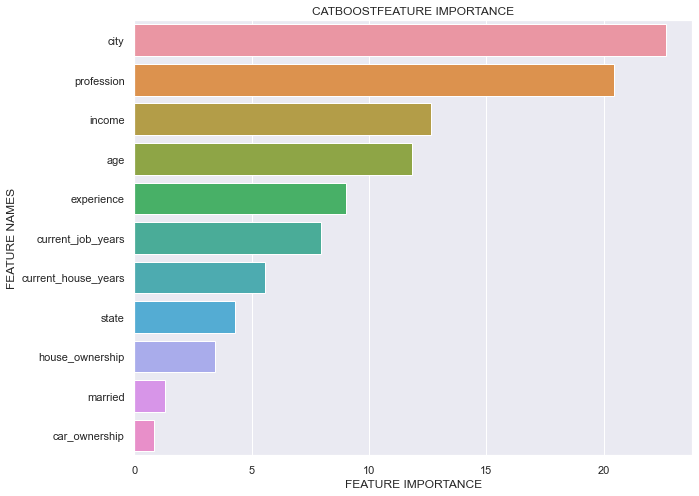

In [11]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf.get_feature_importance(),df_train.columns,'CATBOOST')

In [10]:
df_train = data_preprocess(no_encode=True)[0].drop(["Id", "risk_flag"], axis=1)

In [7]:
from easy_ensembling import generate_ensemble_predictions
def super_tuning():
    def super_eval(**params):
        config = {"device": "gpu", "metric": "auc", "boosting_type": "goss", "verbose": -1}
        config.update(params) 

        config["num_leaves"] = int(round(config["num_leaves"]))
        config["max_bin"] = int(round(config["max_bin"]))
        config["max_depth"] = int(round(config["max_depth"]))

        model_data = {"model": LGBMClassifier(), "params": config, "fit_params": {}}
        generate_ensemble_predictions(models={"super": model_data}, save_dir="./ensemble_files/", target_name="risk_flag")

        val = compare_submissions("./goodsubmits/stacking_sub2.csv", "./ensemble_files/stacking_sub.csv")
        return val
    
    pbounds = {
        "num_leaves": (80, 250),
        "max_bin": (25, 250),
        "scale_pos_weight": (5, 15),
        "colsample_bytree": (0.1, 0.9),
        "subsample": (0.1, 0.9),
        "max_depth": (2, 25)
    }

    lgBO = BayesianOptimization(super_eval, pbounds)
    lgBO.maximize(init_points=15, n_iter=25)
    
    return lgBO
super_tuning()

|   iter    |  target   | colsam... |  max_bin  | max_depth | num_le... | scale_... | subsample |
-------------------------------------------------------------------------------------------------
0.9873303980441916
None


TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

# Discretize income distribution

In [5]:
def scale_by_group(df, cols, groups):
    for col, group in zip(cols, groups):
        df[f"{col}_per_{group}"] = df[col] / df.groupby(group)[col].transform("median")
    return df

No handles with labels found to put in legend.


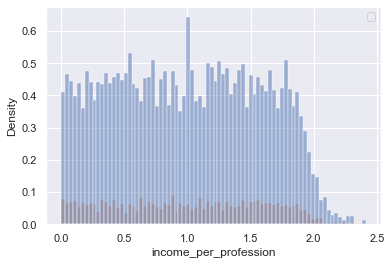

In [9]:
df_train, df_test = data_preprocess()
df_train, df_test = scale_by_group(df_train, ["income"], ["profession"]), scale_by_group(df_test, ["income"], ["profession"])
sns.histplot(x="income_per_profession", data=df_train, stat="density", hue="risk_flag")
# sns.histplot(x="income_per_profession", data=df_test, color="blue", label="Test", stat="density")
plt.legend(loc="upper right")
plt.show()